<a href="https://colab.research.google.com/github/AyHaski/BigDataAnalyticsProject/blob/master/Aylin_Haskioglu_Rapids_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Analytics
Dieses Notebook wurde für das Abschluss Projekt in Big Data Analytics für die Hochschule Offenburg erstellt.

Kaggel ID: 5225680

Kaggel Username: ayhaski

Beste Leaderboard Position: ca 930, genaue Angabe nicht möglich, da die Submission schon nach der Deadline ist

Notebooks die geholfen haben:

https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

https://www.kaggle.com/ravijoe/data-cleaning-eda-modelling


# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

Sat Sep  5 11:53:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
1. removes incompatible files
1. Install RAPIDS libraries
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
1. If running v0.11 or higher, updates pyarrow library to 0.15.x.

In [1]:
# Install RAPIDS and Dask_ml
!pip install dask_ml
!pip install dask_cuda

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable


import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

     |████████████████████████████████| 143kB 3.4MB/s 
     |████████████████████████████████| 6.8MB 8.2MB/s 
     |████████████████████████████████| 655kB 44.1MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=82e4b33d6aabe5cbdde0398125ae33e65f5a0fc0825acbc23c5fa29d43ee5eed
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=ce5b08f2952255e7b3f7680d83f99274f8fd0a906731a64c9cefec0ffff2bd8b
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built contextvars locket
ERROR: distributed 2.26.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
  Found existing installation: scikit-learn 

# Imports und Laden der Daten


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nvstrings
import numpy as np
import cudf, cuml
import dask_cudf
import io, requests
import math
import gc
import cupy as cp

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

#Learning
from cuml.preprocessing.model_selection import train_test_split
from scipy.stats import uniform

# Linear Models
from cuml.linear_model import LinearRegression # Linear
from cuml.linear_model import LogisticRegression # Logisitc
from cuml.linear_model import ElasticNet # Elastic
from cuml.linear_model import Ridge # Ridge
from cuml.linear_model import Lasso # Lasso
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor # Mini Batch SGD Regressor

from cuml.solvers import SGD as cumlSGD # Stochastic Gradient Descent
from cuml.ensemble import RandomForestRegressor as cuRF # Random Forest
from cuml.neighbors import KNeighborsRegressor  # Nearest Neighbours
from cuml.svm import SVR # Support Vector Machines

from cuml import ForestInference
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from cuml.metrics.regression import r2_score
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.utils.fixes import loguniform

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: nvstrings will be removed in 0.15. Please use equivalent from libcudf
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
cudf.set_allocator("managed")
#base_path='/content/drive/My Drive/bigData'
base_path=''

traintypes = {'fare_amount': 'float32',
              'pickup_datetime':'str',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'int8'}

cols = list(traintypes.keys())
usecols = cols

In [5]:
%%time
test_1 = cudf.read_csv(base_path +'/test.csv', usecols=cols, dtype=traintypes)
train_1 = cudf.read_csv(base_path +'/train.csv', usecols=cols, dtype=traintypes)

CPU times: user 3.45 s, sys: 3.16 s, total: 6.61 s
Wall time: 1min 53s


In [6]:
train_1.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844307,40.721321,-73.841614,40.712273,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982742,40.761269,-73.991234,40.750565,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987137,40.733139,-73.991570,40.758095,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968102,40.768009,-73.956665,40.783768,1


In [7]:
train_1['pickup_datetime'] = train_1['pickup_datetime'].astype('datetime64[ns]')
test_1['pickup_datetime'] = test_1['pickup_datetime'].astype('datetime64[ns]')

In [8]:
#Getting integer numbers from the pickup_datetime
train_1["hour"] = train_1.pickup_datetime.dt.hour
train_1["weekday"] = train_1.pickup_datetime.dt.weekday
train_1["month"] = train_1.pickup_datetime.dt.month
train_1["year"] = train_1.pickup_datetime.dt.year

test_1["hour"] = test_1.pickup_datetime.dt.hour
test_1["weekday"] = test_1.pickup_datetime.dt.weekday
test_1["month"] = test_1.pickup_datetime.dt.month
test_1["year"] = test_1.pickup_datetime.dt.year

In [9]:
train_1.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
0,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010
2,5.7,2011-08-18 00:35:00,-73.982742,40.761269,-73.991234,40.750565,2,0,3,8,2011
3,7.7,2012-04-21 04:30:42,-73.987137,40.733139,-73.991570,40.758095,1,4,5,4,2012
4,5.3,2010-03-09 07:51:00,-73.968102,40.768009,-73.956665,40.783768,1,7,1,3,2010


# Data Cleaning and Analysis


Bevor mit den Daten gearbeitet werden kann sollten diese betrachtet um mögliche Null Werte und Outliers zu finden und zu entfernen. So können auch schon mögliche Abhängigkeiten zwischen den Datenspalten erkannt werden.


## Null Data

In [10]:
print("Shape of Training Data",train_1.shape)
print("Shape of Testing Data",test_1.shape)

Shape of Training Data (55423856, 11)
Shape of Testing Data (9914, 10)


In [11]:
train_1.nans_to_nulls()
train_1 = train_1.dropna()
print("Shape of Training Data after removing null data",train_1.shape)
print("Shape of Testing Data after removing null datat",test_1.shape)

Shape of Training Data after removing null data (55423480, 11)
Shape of Testing Data after removing null datat (9914, 10)


In [12]:
train_1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
count,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07
mean,1.134501e+01,-7.250973e+01,3.991982e+01,-7.251121e+01,3.992068e+01,1.685087e+00,1.350978e+01,3.041161e+00,6.266239e+00,2.011739e+03
std,2.071087e+01,1.284877e+01,9.642324e+00,1.278220e+01,9.633346e+00,1.310113e+00,6.517377e+00,1.948911e+00,3.435531e+00,1.860079e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442024e+03,-3.547886e+03,-1.270000e+02,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03
25%,6.000000e+00,-7.399206e+01,4.073493e+01,-7.399139e+01,4.073403e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398016e+01,4.075315e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03
max,9.396336e+04,3.457625e+03,3.408790e+03,3.457622e+03,3.537133e+03,5.100000e+01,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03


## Fare amount and Passenger Count

In [13]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()

Text(0.5, 1.0, 'Verteilung der Gäste')

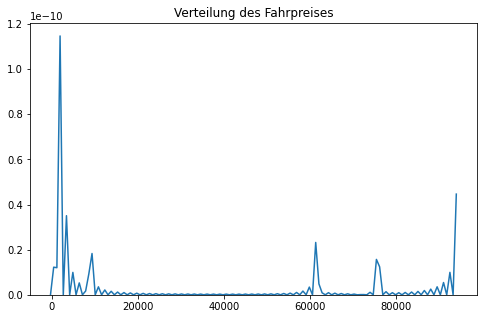

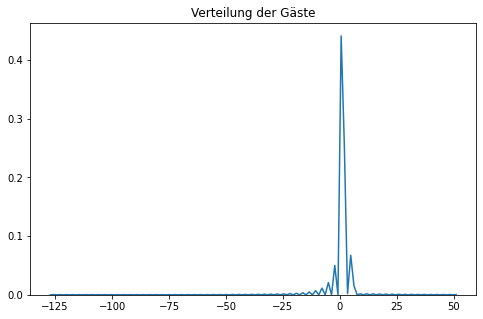

In [14]:
plt.figure(figsize=(8,5))
sns.kdeplot(fare_amount).set_title("Verteilung des Fahrpreises")

plt.figure(figsize=(8,5))
sns.kdeplot(passenger_count).set_title("Verteilung der Gäste")

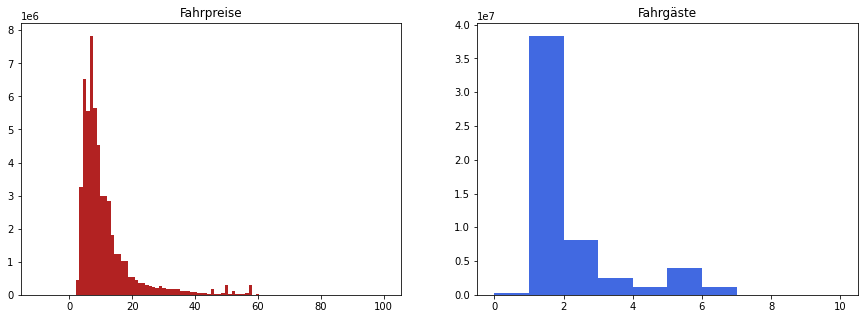

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.hist(fare_amount, bins=100, range=(-10,100), color='firebrick')
ax1.set_title('Fahrpreise')

ax2.hist(passenger_count,bins=10, range=(0,10), color='royalblue')
ax2.set_title('Fahrgäste')
plt.show()

Insgesamt sieht man durch diese Graphen das meistens 1 bis 2 Passagiere ein Taxi verwenden und das meistens die Gebühren zwischen 2 und 20 Dollar liegen. 

Von der Graphen und der Informationen kann geshen werden, das es Einträge gibt die unter 0 sind für die Fare_mount und Passenger_count. Diese Einträge könnten Fehler sein und werden entfernt, da sie das Ergebnis ins negative beeinflüssen können. Für die Passenger_Count gibt es zudem Einträge, welche über 8 Passagiere angibt, was Logistisch nicht möglich ist, so werden diese Einträge auch entfernt.

In [16]:
train_1 = train_1[(train_1['fare_amount'] > 0) & (train_1['fare_amount'] < 20000)]
train_1 = train_1[(train_1['passenger_count'] > 0) & (train_1['passenger_count'] < 9)]
print("Shape of Training Data",train_1.shape)

Shape of Training Data (55224530, 11)


## Longitude and Latitude

Als nächstes werden die Pickup und Dropoff Punkte betrachtet. Wir durch die Informationen, welche durch das .describe erhalten haben zu sehen ist, gibt es einige sehr entfernte Werte. Der Mittelpunkt von Newyork liegt bei einer Latitude 40 und Longitude -74. Also wollen wir zuerset den Bereich um New York herum betrachten






In [17]:
dropoff_long = train_1['dropoff_longitude'].to_array()
dropoff_lat = train_1['dropoff_latitude'].to_array()
pickup_long = train_1['pickup_longitude'].to_array()
pickup_lat = train_1['pickup_latitude'].to_array()

In [18]:
city_long_border = (-75, -73)
city_lat_border = (40, 42)

(-75.0, -73.0)

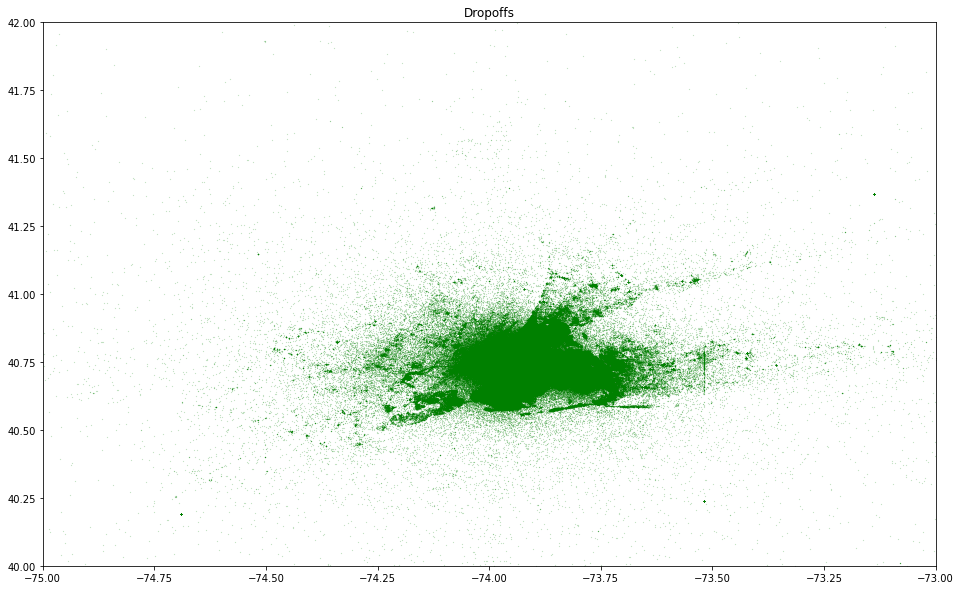

In [19]:
plt.figure(figsize=(16,10))
plt.scatter(dropoff_long, dropoff_lat,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-75.0, -73.0)

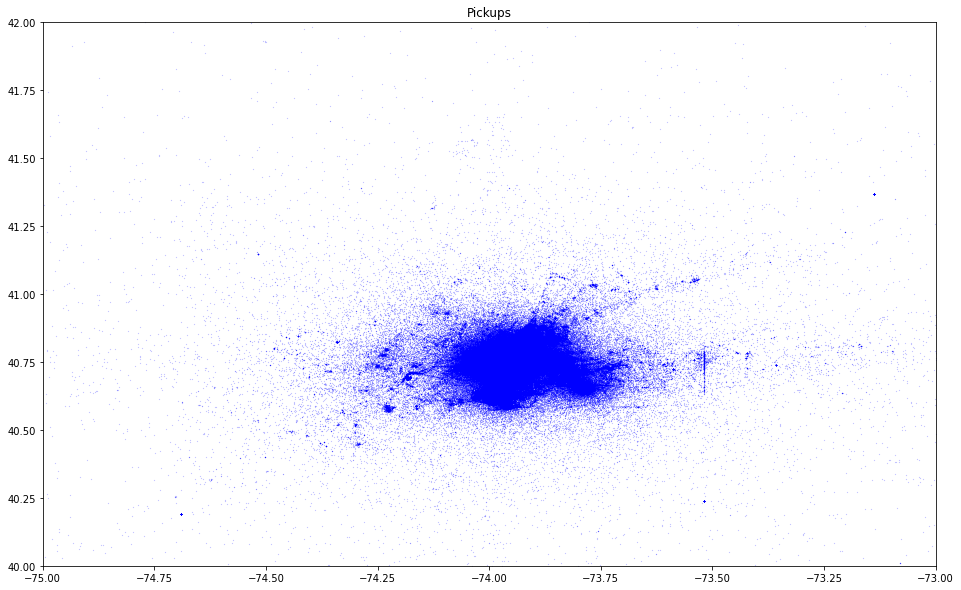

In [20]:
plt.figure(figsize=(16,10))
plt.scatter(pickup_long, pickup_lat,
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Die Minimalen und Maximalen Werte wurden nochmal in einer kleinen Tabelle zusammengefasst.


| Min Lat   | Max Lat   | Min Long  |  Max Long |
|:---------:| ---------:| ---------:| ---------:|
| -3492.2637| 3406.0083 |-3439.2449 | 3457.6255 |

Betrachtet man eine Heatmap der Punkte wird deutlich das es viele Punkte gibt die außerhalb von New York liegen. Daher sollten die Daten in eine Art Bounding Box eingegrenzt werden, womit das Ergebnis der Vorhersage genauer werden sollte.

Für das Eingrenzen werden die maximalen und minimalen Werte des Testsets verwendet

In [21]:
min_long = min(train_1['pickup_longitude'].min(), train_1['pickup_longitude'].min())
max_long = max(train_1['pickup_longitude'].max(), train_1['pickup_longitude'].max())

min_lat = min(train_1['pickup_latitude'].min(), train_1['pickup_latitude'].min())
max_lat = max(train_1['pickup_latitude'].max(), train_1['pickup_latitude'].max())

print ('Trainset Minimum und Maximum Longitude: ', min_long, ',', max_long)
print ('Trainset Minimum und Maximum Latitude: ', min_lat, ',', max_lat)

min_long = min(test_1['pickup_longitude'].min(), test_1['pickup_longitude'].min())
max_long = max(test_1['pickup_longitude'].max(), test_1['pickup_longitude'].max())

min_lat = min(test_1['pickup_latitude'].min(), test_1['pickup_latitude'].min())
max_lat = max(test_1['pickup_latitude'].max(), test_1['pickup_latitude'].max())

print ('Testset Minimum und Maximum Longitude: ', min_long, ',', max_long)
print ('Testset Minimum und Maximum Latitude: ', min_lat, ',', max_lat)

Trainset Minimum und Maximum Longitude:  -3442.0596 , 3457.6255
Trainset Minimum und Maximum Latitude:  -3492.2637 , 3408.7896
Testset Minimum und Maximum Longitude:  -74.25219 , -72.986534
Testset Minimum und Maximum Latitude:  40.57314 , 41.709553


In [22]:
min_long = math.floor(min_long) #-74.5
max_long = math.ceil(max_long) #-72.5
min_lat = math.floor(min_lat) #40.5
max_lat = math.ceil(max_lat)

city_long_border_zoomed = (min_long, max_long)
city_lat_border_zoomed = (min_lat, max_lat)

print ('Gerundet Testset Minimum und Maximum Longitude: ', min_long, ',', max_long)
print ('Gerundet Testset Minimum und Maximum Latitude: ', min_lat, ',', max_lat)

Gerundet Testset Minimum und Maximum Longitude:  -75 , -72
Gerundet Testset Minimum und Maximum Latitude:  40 , 42


(-75.0, -72.0)

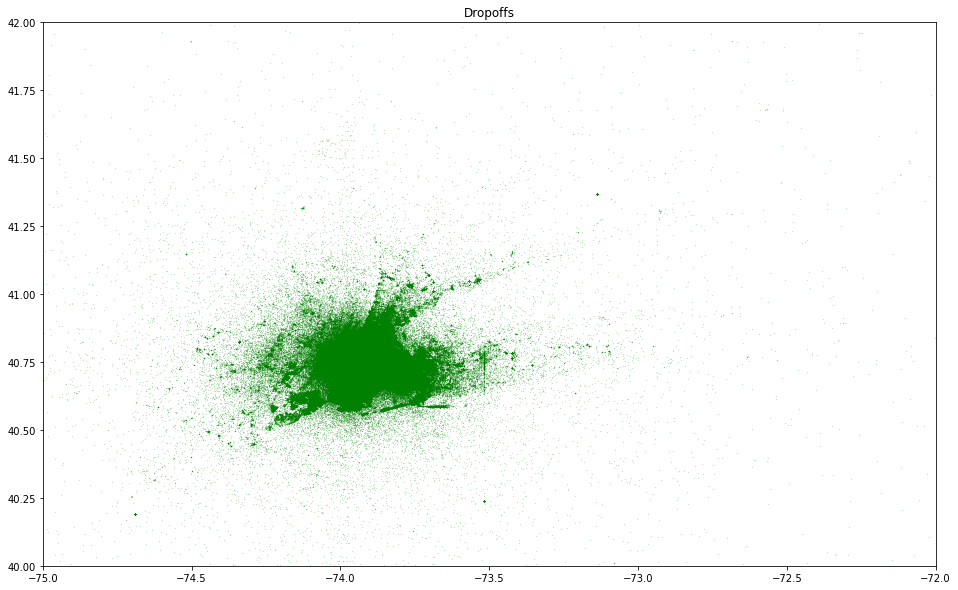

In [23]:
plt.figure(figsize=(16,10))
plt.scatter(dropoff_long, dropoff_lat,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border_zoomed)
plt.xlim(city_long_border_zoomed)

(-75.0, -72.0)

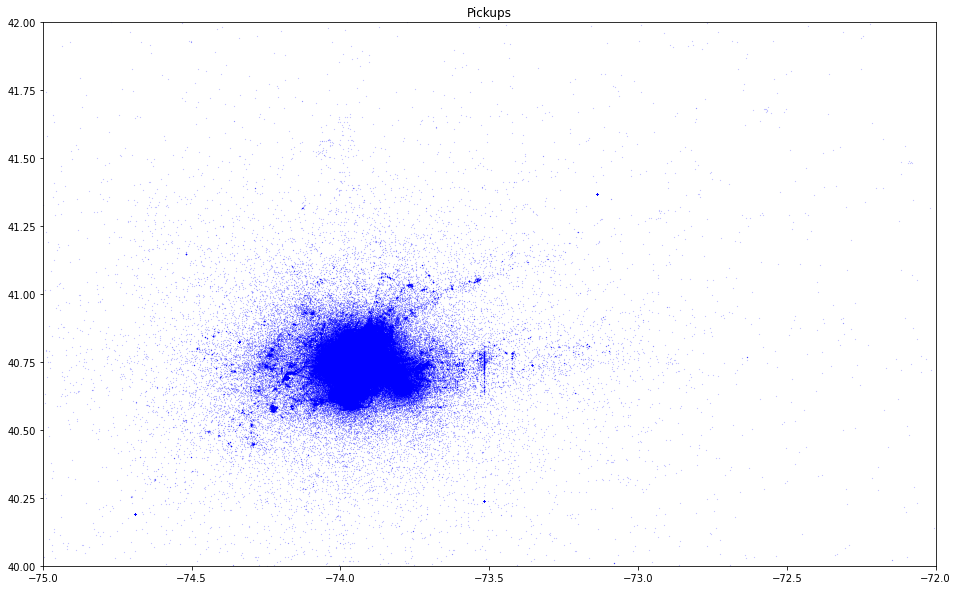

In [24]:
plt.figure(figsize=(16,10))
plt.scatter(pickup_long, pickup_lat,
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border_zoomed)
plt.xlim(city_long_border_zoomed)

Die Daten werden auf einer Longtitude von (-75, -72) und Latitude von (40, 42) eingegrenzt

In [25]:
train_1 = train_1[(train_1['pickup_longitude'] < max_long) & (train_1['pickup_longitude'] > min_long)]
train_1 = train_1[(train_1['pickup_latitude'] > min_lat) & (train_1['pickup_latitude'] < max_lat)]
train_1 = train_1[(train_1['dropoff_longitude'] < max_long) & (train_1['dropoff_longitude'] > min_long)]
train_1 = train_1[(train_1['dropoff_latitude'] > min_lat) & (train_1['dropoff_latitude'] < max_lat)]

print("Shape of Training Data after distance calculations", train_1.shape)
train_1.describe()

Shape of Training Data after distance calculations (54063079, 11)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
count,5.406308e+07,5.406308e+07,5.406308e+07,5.406308e+07,5.406308e+07,5.406308e+07,5.406308e+07,5.406308e+07,5.406308e+07,5.406308e+07
mean,1.133069e+01,-7.397515e+01,4.075105e+01,-7.397431e+01,4.075140e+01,1.691136e+00,1.351014e+01,3.041115e+00,6.269598e+00,2.011738e+03
std,9.796774e+00,3.912800e-02,3.001700e-02,3.835900e-02,3.322500e-02,1.306958e+00,6.516850e+00,1.949126e+00,3.436413e+00,1.865564e+00
min,1.000000e-02,-7.499804e+01,4.000212e+01,-7.499828e+01,4.000201e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03
25%,6.000000e+00,-7.399227e+01,4.073656e+01,-7.399159e+01,4.073558e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03
50%,8.500000e+00,-7.398210e+01,4.075337e+01,-7.398061e+01,4.075386e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03
75%,1.250000e+01,-7.396830e+01,4.076756e+01,-7.396533e+01,4.076840e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03
max,9.000410e+03,-7.200594e+01,4.199717e+01,-7.201388e+01,4.199811e+01,8.000000e+00,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03


## Abhängigkeiten

Am Ende sollten die Daten noch auf verschiedene Abhängigkeiten gecheckt werden. Also wird überprüft ob die Fare_amount etwas mit der Datetime, den Passagieren und die Distanz zu tun hat.
Für das sollte muss zuerst noch die Distanz berechnet werden. Zwei verschiedene Berechnung wurden auspobiert während dem Anfang des Projekts. Einmal die absolute Distanz und einmal die Distanz mit der Haversine Formel. Bei den Anfangsversuchen mit simplere Modelle erschließte sich ein Score-Unterschied von 1-2 Punkten. Somit wurde sich letztendlich für die Harvesine Formel entschieden.  

In [26]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()
hour = train_1["hour"].to_array()
weekday = train_1["weekday"].to_array()
month =train_1["month"].to_array()
year = train_1["year"].to_array()

### Distance in miles

In [27]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [28]:
train_1['distance_miles'] = distance(train_1['pickup_latitude'], train_1['pickup_longitude'], \
                                      train_1['dropoff_latitude'], train_1['dropoff_longitude'] )
test_1['distance_miles'] = distance(test_1['pickup_latitude'], test_1['pickup_longitude'], \
                                      test_1['dropoff_latitude'], test_1['dropoff_longitude'] )
train_1['distance_miles'].describe()

count    5.406308e+07
mean     1.861837e+00
std      2.489766e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.366828e+00
75%      2.424855e+00
max      1.469736e+02
Name: distance_miles, dtype: float64

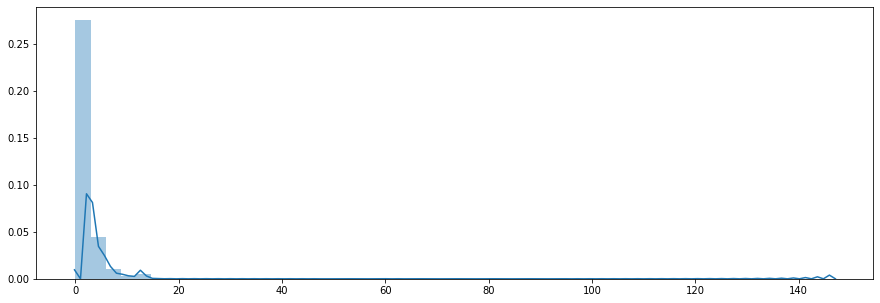

In [29]:
distance = train_1['distance_miles'].to_array()

plt.figure(figsize=(15,5))
sns.distplot(distance)

Durch das Histogramm sieht man, das die meisten Fahrten sehr kurz sind un unter 5 Miles liegen.

Text(0, 0.5, 'Fare')

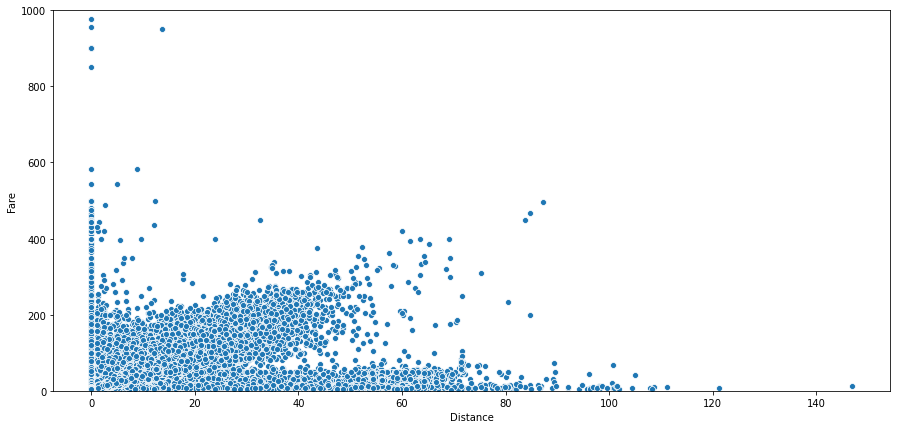

In [30]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=distance, y=fare_amount)
plt.ylim(0,1000)
plt.xlabel('Distance')
plt.ylabel('Fare')

Durch den Scatter Plot kann eine lineare Abhängikeit zwischen Fahrpreis und Distanz erkannt werden. Es bestehen zudem viele Trips die zwar länger sind aber weniger kosten, welche möglicherweise feste Preise hatten oder Reduzierungen. Was auch interessant ist, dass es anscheinend viele Fahrten gibt, die kaum eine Distanz haben. Es könnte sein, dass diese ein Roundtrip sind oder ähnliches.

### Datetime

In [31]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()
distance = train_1['distance_miles'].to_array()
hour = train_1["hour"].to_array()
weekday = train_1["weekday"].to_array()
month =train_1["month"].to_array()
year = train_1["year"].to_array()

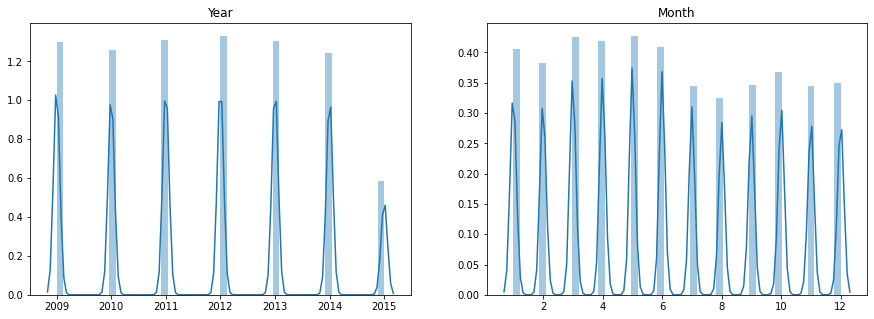

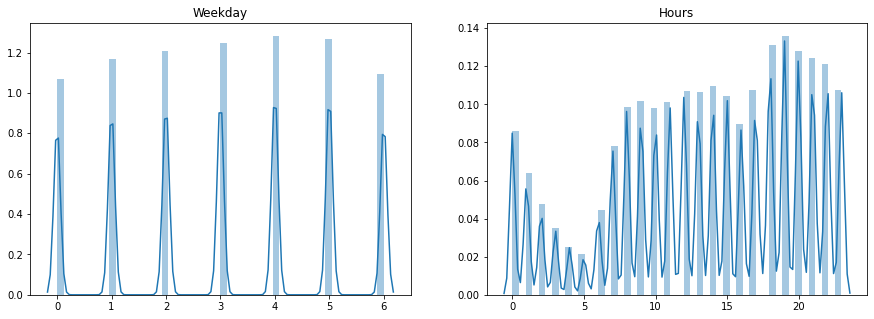

In [32]:
fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Year')
sns.distplot(year, ax=ax1)

ax2.set_title('Month')
sns.distplot(month, ax=ax2)
plt.show()

fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Weekday')
sns.distplot(weekday, ax=ax1)

ax2.set_title('Hours')
sns.distplot(hour, ax=ax2)
plt.show()

Betrachtet man die Datetime erkennt man das in den Monaten von Juli bis Oktober weniger Fahrten getätigt wurden. Das könnte an dem besseren Wetter und mögliche Urlaube liegen, wo regelmäßige Taxifahrten nicht mehr stattfinden.
Die beschäftigsten Wochentage sind gegen das Wochenende und Stunden mit den meisten Fahrten liegen am Abend bis Mitternacht, wahrscheinlich da die meisetn Leute um diese Uhrzeit schnell nach Hause wollen oder auch selbst nicht mehr fahren oder laugen können durch Konsum von Alkohol.

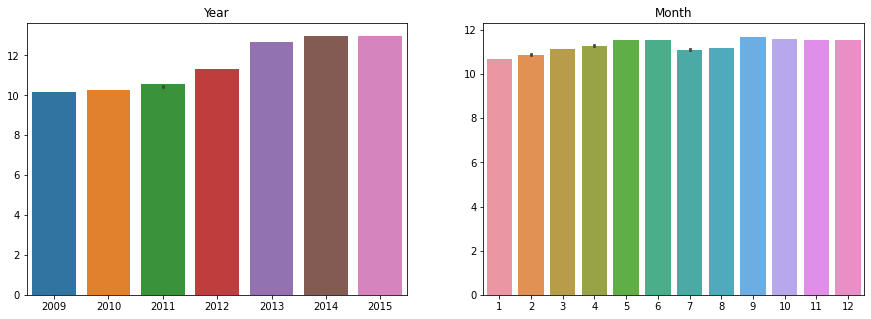

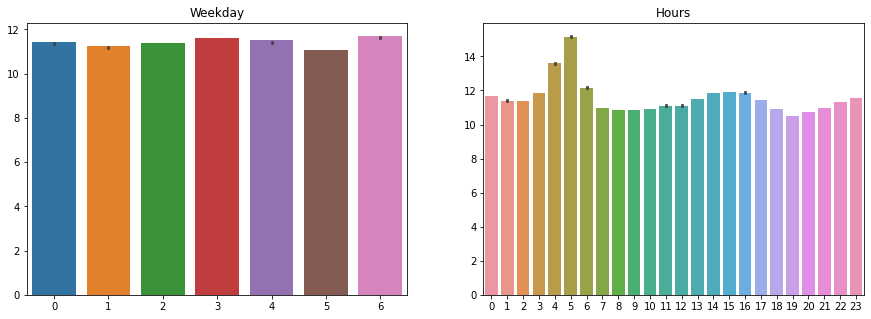

In [33]:
fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Year')
sns.barplot(x=year, y=fare_amount,ax=ax1)

ax2.set_title('Month')
sns.barplot(x=month, y=fare_amount,ax=ax2)
plt.show()

fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Weekday')
sns.barplot(x=weekday, y=fare_amount,ax=ax1)

ax2.set_title('Hours')
sns.barplot(x=hour, y=fare_amount,ax=ax2)
plt.show()

Betrachtete man nun die Datetime mit Abhängigkeit auf die Fahrgebühren, sieht man das die Preise pro Jahr gestiegen sind. Die teuersten Monate sind von Mai bis Juni und September bis Dezember, welches wahrscheinlich dem Wetter geschuldet ist. Die teuersten Tage sind am Sonntag und Monatg und die teuersten Stunden sind die sehr frühren Morgenstunden von 4 bis 6 Uhr.

### Passenger Count


In [34]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()
distance = train_1['distance_miles'].to_array()
hour = train_1["hour"].to_array()
weekday = train_1["weekday"].to_array()
month =train_1["month"].to_array()
year = train_1["year"].to_array()

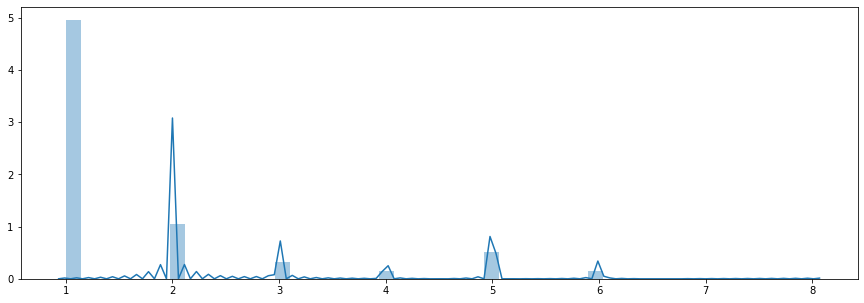

In [35]:
plt.figure(figsize=(15,5))
sns.distplot(passenger_count)

Text(0, 0.5, 'Fahrgebühr')

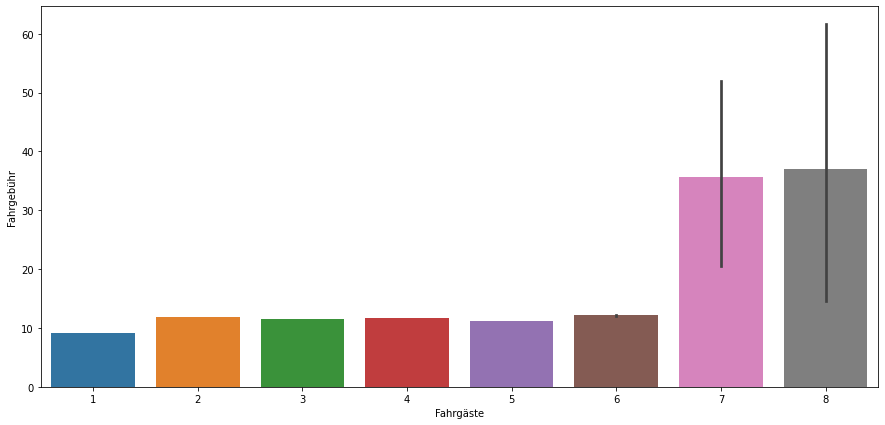

In [36]:
plt.figure(figsize=(15,7))
sns.barplot(x=passenger_count, y=fare_amount)
plt.xlabel('Fahrgäste')
plt.ylabel('Fahrgebühr')

Wie schon erahnt sind die teuersten Fahrten die mit den meisten Leuten und die günstigsten die mit einer Person.

In [37]:
print("Shape of Training Data after cleaning data", train_1.shape)

Shape of Training Data after cleaning data (54063079, 12)


# Spalten entfernen die nicht mehr benötigt werden


Nachdem die Daten gesäubert und analysiert wurden, werden die nicht notwendigen Datenspalten entfernt. Es werden die Longitude und Latitude Felder entfernt, da diese in der neu berechneten Distanzspalte wiederfinden. Die Pickup_datetime Spalte wird auch entfernt, da diese auf ihre jeweiligen Komponenten aufgeteilt wurde. 

In [38]:
drop_columns = ['pickup_datetime','dropoff_latitude','pickup_latitude','dropoff_longitude','pickup_longitude']
train_1=train_1.drop(drop_columns,axis=1)
test_1=test_1.drop(drop_columns,axis=1)

In [39]:
train_1.head()

,fare_amount,passenger_count,hour,weekday,month,year,distance_miles
0,4.5,1,17,0,6,2009,0.000000
1,16.9,1,16,1,1,2010,5.244397
2,5.7,2,0,3,8,2011,0.000000
3,7.7,1,4,5,4,2012,1.932986
4,5.3,1,7,1,3,2010,1.366828


In [40]:
test_1.head()

,passenger_count,hour,weekday,month,year,distance_miles
0,1,13,1,1,2015,1.366828
1,1,13,1,1,2015,1.366828
2,1,11,5,10,2011,0.000000
3,1,21,5,12,2012,1.366828
4,1,21,5,12,2012,3.226874


# Training

In [46]:
optimize=False

def saveResults(y_pred, filename):
  gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
  gdf_submission['fare_amount']= y_pred
  gdf_submission.to_csv(base_path + filename, index=False)
  return gdf_submission.head()

## Linear Regression

In [42]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ", X_train.shape[0])
print("Number of records in validation data ", X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  43250464
Number of records in validation data  10812615
(43250464, 6)
(10812615, 6)
(43250464,)
(10812615,)


In [43]:
lm = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "eig")

lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)
lm_rmse = r2_score(y_pred, y_test)

print("RMSE for Linear Regression is ", lm_rmse)

y_pred = lm.predict(test_1)
saveResults(y_pred, '/linearRegressionSubmission2.csv')

RMSE for Linear Regression is  0.5108813643455505


,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.701904
1,2015-01-27 13:08:24.0000003,9.701904
2,2011-10-08 11:53:44.0000002,4.850281
3,2012-12-01 21:12:12.0000002,9.542816
4,2012-12-01 21:12:12.0000003,15.447357


Die Lineare Regression brachte bei Kaggel einen Score von 5.52997 womit es besser als das Basic Linear Model auf Kaggel ist, allerdings noch viel Verbesserungspotenzial zeigt.

## Ridge Regression


Für Ridge Regression wurde Hyperparameter Optimierung angewendet für die Parameter alpha und solver mit Hilfe von RandomizedSearchCV.
 

In [47]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  43250464
Number of records in validation data  10812615
(43250464, 6)
(10812615, 6)
(43250464,)
(10812615,)


In [48]:
if optimize:
  params_ridge = {
      "alpha": loguniform(1e-5, 1e0), # default 1.0
      "solver": ['eig', 'cd'], 
  }
  ridge = Ridge()
  clf = RandomizedSearchCV(ridge, params_ridge, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=1)
  best_model = clf.fit(X_train,y_train)
  best_model.best_estimator_.get_params()

In [49]:
ridge_params = {'alpha': 0.001216494146415184,
 'fit_intercept': True,
 'normalize': False,
 'solver': 'eig'
 }
 
if optimize:
  ridge_params= best_model.best_estimator_.get_params()

ridge = Ridge(**ridge_params)
result_ridge = ridge.fit(X_train,y_train)

y_pred = result_ridge.predict(X_test)
ridge_rmse = r2_score(y_pred, y_test)
print("RMSE for Ridge_rmse Regression is ", ridge_rmse)

y_pred = result_ridge.predict(test_1)
saveResults(y_pred, '/ridgeRegressionSubmission2.csv')

RMSE for Ridge_rmse Regression is  0.5060502290725708


,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.702545
1,2015-01-27 13:08:24.0000003,9.702545
2,2011-10-08 11:53:44.0000002,4.847168
3,2012-12-01 21:12:12.0000002,9.542023
4,2012-12-01 21:12:12.0000003,15.448669


Bei der Ridge Regression wurde ein Kaggle Score von 5.53031, was eine minimale Veränderung des vorherigen Scores ist. Da sich der Unterschied allerdings minimal ist, kann kaum von einer wirklichen Verschlechterung gesprochen werden. Die Ridge Regression bringt also nicht viel mehr als eine normale Lineare Regression.

## Lasso Regression


In [50]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  43250464
Number of records in validation data  10812615
(43250464, 6)
(10812615, 6)
(43250464,)
(10812615,)


In [51]:
if optimize:
  params_lasso = {
      "alpha": loguniform(1e-5, 1e0),
      "max_iter": np.arange(start=500, stop = 3000, step = 500),
      "tol": loguniform(1e-5, 1e0), 
      "selection": ['cyclic', 'random'],
  }

  lasso = Lasso()
  clf = RandomizedSearchCV(lasso, params_lasso, random_state=1, n_iter=1000, cv=5, verbose=0, n_jobs=1)
  best_model = clf.fit(X_train,y_train) 
  best_model.best_estimator_.get_params()

In [52]:
lasso_params = {'alpha': 0.001216494146415184,
 'fit_intercept': True,
 'max_iter': 2500,
 'normalize': False,
 'selection': 'cyclic',
 'tol': 1.0013176560941263e-05}

if optimize:
  lasso_params= best_model.best_estimator_.get_params()
  
lasso = Lasso(**lasso_params)
result_lasso = lasso.fit(X_train,y_train)
y_pred=result_lasso.predict(X_test)
lasso_rmse = r2_score(y_pred, y_test)
print("RMSE for Lasso Regression is ", lasso_rmse)

y_pred = result_lasso.predict(test_1)
saveResults(y_pred, '/lassoRegressionSubmission2.csv')

RMSE for Lasso Regression is  0.48861902952194214


,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.699646
1,2015-01-27 13:08:24.0000003,9.699646
2,2011-10-08 11:53:44.0000002,4.843048
3,2012-12-01 21:12:12.0000002,9.542786
4,2012-12-01 21:12:12.0000003,15.456177


Bei der Lasso Regression wurde ein Kaggel Score 5.53151 erreicht, also im gleichen Bereich wie die vorherigen Regressions Modelle. Insgesamt kann gesagt werden das zwischen Linear, Ridge und Lasso kaum ein Unterschied festzustellen ist. Linear Regression bringt noch das beste Ergebnis.

## Random Forest Regression Model

Die Verwendung der RandomizedSearchCV für das Random Forest Regression Model führte leider zu ständigen Laufzeitabbrüchen und wurde so nicht verwendet. An sich wurde per Hand mit den Hyperparameter experimentiert

In [53]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [54]:
cu_rf_params = {
    'n_estimators': 300,
    'max_depth': 16,
    'n_bins': 10
}

cu_rf = cuRF(**cu_rf_params)
cu_rf.fit(X_train, y_train)
y_pred=cu_rf.predict(X_test)

rf_rmse = r2_score(y_pred, y_test)
print("RMSE for RF Regression is ", rf_rmse)

y_pred = cu_rf.predict(test_1)
saveResults(y_pred, '/rfRegressionSubmission2.csv')

RMSE for RF Regression is  0.24910742044448853


,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.938229
1,2015-01-27 13:08:24.0000003,9.938229
2,2011-10-08 11:53:44.0000002,6.041118
3,2012-12-01 21:12:12.0000002,8.957006
4,2012-12-01 21:12:12.0000003,17.671265


Für Random Forest wurde ein Kaggel Score 5.23771 erreicht, was auch wieder ca im gleichen Bereich der vorherigen Modelle liegt. Da leider keine Hyperparameter Optimierung durch den Verbrauch durch RAM möglich war, könnte dies allerdings auch an der Auswahl an Parameter liegen.

## XGBoost

Als nächste wird XGBoost ausprobiert und auch hier die Hyperparameter Optimierung angewendet

In [63]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [64]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_test, label=y_test)

In [57]:
if optimize:
  params_xgb1={
      "min_child_weight" : np.arange(start=2, stop=12, step=2), # default = 1
      "max_depth": np.arange(start=3, stop = 10, step = 1), # Default = 6
  }

  params_xgb2={
      "gamma": np.arange(start=0, stop=0.5, step=0.1),
  }

  params_xgb3={
      "colsample_bytree": np.arange(start=0.4, stop=1, step=0.1),
      "subsample": np.arange(start=0.4, stop=1, step=0.1),
  }
  params_xgb4={
      "reg_alpha": [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
  }

  params_xgb5 = {
      "learning_rate":  [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3], #default = 0.3
      "n_estimators": [100, 250, 500, 750, 1000]
  }
  y_cpu = y_train.to_array()
  xgb_model = xgb.XGBRegressor(tree_method='gpu_hist')

  clf = RandomizedSearchCV(xgb_model, params_xgb1, random_state=1, n_iter=100, cv=5, verbose=10, n_jobs=1)
  best_model = clf.fit(X_train,y_cpu)
  print(best_model.best_estimator_.get_params())

  clf = RandomizedSearchCV(xgb_model, params_xgb2, random_state=1, n_iter=100, cv=5, verbose=10, n_jobs=1)
  best_model = clf.fit(X_train,y_cpu)
  print(best_model.best_estimator_.get_params())

  clf = RandomizedSearchCV(xgb_model, params_xgb3, random_state=1, n_iter=100, cv=5, verbose=10, n_jobs=1)
  best_model = clf.fit(X_train,y_cpu)
  print(best_model.best_estimator_.get_params())

  clf = RandomizedSearchCV(xgb_model, params_xgb4, random_state=1, n_iter=50, cv=5, verbose=10, n_jobs=1)
  best_model = clf.fit(X_train,y_cpu)
  print(best_model.best_estimator_.get_params())

  clf = RandomizedSearchCV(xgb_model, params_xgb5, random_state=1, n_iter=100, cv=5, verbose=10, n_jobs=1)
  best_model = clf.fit(X_train,y_cpu)
  print(best_model.best_estimator_.get_params())

Durch das Aufteilen der Parameter ergaben sich folgende Hyperparameterwerte:

'max_depth': 7,

'min_child_weight': 6,

'gamma': 0.0, 
 
'colsample_bytree': 0.9,

'subsample': 0.9,

'reg_alpha': 1,

'learning_rate': 0.075





In [65]:
# instantiate params
params = {}

# booster params
booster_params = {}

booster_params['tree_method'] = 'gpu_hist'
params.update(booster_params)

# learning task params
learning_task_params = {}
learning_task_params['eval_metric'] = 'rmse'
learning_task_params['objective'] = 'reg:squarederror'
params.update(learning_task_params)

# have to change manually when using optimizing
params_xgb = {
    "max_depth": 7, 
    "alpha" : 1,
    "learning_rate":  0.075,
    "min_child_weight" : 6,
    'colsample_bytree': 0.9, 
    'subsample': 0.9,
    "n_estimators": 1000
}
params.update(params_xgb)

print(params)

{'tree_method': 'gpu_hist', 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'max_depth': 7, 'alpha': 1, 'learning_rate': 0.075, 'min_child_weight': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'n_estimators': 1000}


In [66]:
# model training settings
evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
num_round = 500

In [67]:
bst = xgb.train(params, dtrain, num_round, evallist)

[18:55:04] WARNING: /conda/conda-bld/xgboost_1591204502249/work/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-rmse:13.58863	train-rmse:13.65202
[1]	validation-rmse:12.70142	train-rmse:12.76955
[2]	validation-rmse:11.88987	train-rmse:11.96298
[3]	validation-rmse:11.15457	train-rmse:11.23275
[4]	validation-rmse:10.47789	train-rmse:10.56145
[5]	validation-rmse:10.09208	train-rmse:10.17882
[6]	validation-rmse:9.74987	train-rmse:9.83966
[7]	validation-rmse:9.44720	train-rmse:9.53986
[8]	validation-rmse:8.92554	train-rmse:9.02388
[9]	validation-rmse:8.68372	train-rmse:8.78478
[10]	validation-rmse:8.23537	train-rmse:8.34225
[11]	validation-rmse:7.83115	train-rmse:7.94382
[12]	validation-rmse:7.46738	train-rmse:7.58578
[

In [68]:
dtest = xgb.DMatrix(test_1)
y_pred_xgb = bst.predict(dtest)
print(y_pred_xgb)

[ 9.544798  9.544798  5.694167 ... 55.511936 23.490553  6.071633]


In [69]:
gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
gdf_submission['fare_amount']= y_pred_xgb

gdf_submission.to_csv(base_path + '/XGBBoostSubmission2.csv',index=False)
gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.544798
1,2015-01-27 13:08:24.0000003,9.544798
2,2011-10-08 11:53:44.0000002,5.694167
3,2012-12-01 21:12:12.0000002,9.206911
4,2012-12-01 21:12:12.0000003,16.490742


XGBoost lieferte einen Kaggel Score von 3.92450, den bisher besten Score aller Modelle.

## SVR

Bei der Verwendung von SVR tauchte das Problem der Speicherverwendung auf. Deswegen werden nur 2000000 Milionen Datensätze verwendet. Dies hat aber wahrscheinlich keinen großen Einfluss auf den Score, da SVR mit 5.48408 abschneidet und so sogar besser ist, als die simplen Regressions Modelle.

In [72]:
X=train_1.drop(['fare_amount'],axis=1)[:2000000]
y=train_1['fare_amount'][:2000000]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [73]:
svr = SVR(kernel='rbf', gamma='scale', C=30, epsilon=0.1, cache_size=1000)

result = svr.fit(X_train,y_train)
y_pred = result.predict(X_test)
svr_rmse = r2_score(y_pred, y_test)
print("RMSE for SVR Regression is ", svr_rmse)

y_pred = result.predict(test_1)
saveResults(y_pred, '/svrSubmissionC30_2.csv')

RMSE for SVR Regression is  0.4334551692008972


,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.065144
1,2015-01-27 13:08:24.0000003,10.065144
2,2011-10-08 11:53:44.0000002,4.693684
3,2012-12-01 21:12:12.0000002,9.394489
4,2012-12-01 21:12:12.0000003,14.937580


# Fazit

Durch den Vergleich der verschiedenen Modelle kann gesehen werden, das die besten Ergbenisse mit XGBoost erzielt wurden und die zweitbesten mit Random Forest. Unter den simplen Regressionsmodelle gibt es kaum einen Unterschied, was den Score betrifft.